In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import numpy as np
import re
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt  # Added for plotting
from nltk.stem import WordNetLemmatizer
import optuna
import pandas as pd
import pickle
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
import torch.nn.functional as F

c:\Users\Admin\Desktop\SC4002_Natural-Language-Processing_Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_glove = load_glove_embeddings('glove_files/glove.6B.300d.txt')


In [11]:
embedding_dim = 300
embeddings_glove['<pad>'] = np.zeros(embedding_dim)
embeddings_glove['<unk>'] = np.random.normal(size = embedding_dim) #follow pytorch default initialization

In [13]:
with open(r'C:\Users\Admin\Desktop\SC4002_Natural-Language-Processing_Project\embedding_dictionary_wo_unkns.pkl', 'rb') as f:
    embedding_dict = pickle.load(f)

In [14]:
#merge both dicts, keeping the values from the glove embeddings
final_dict = {**embedding_dict, **embeddings_glove}
print(len(final_dict))

401484


In [5]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']


In [15]:
# Create word-to-index and index-to-word mappings
vocab_new = {}
index = 0
for word, emb in final_dict.items():
    #print(word)
    vocab_new[word] = index
    index += 1
embedding_matrix_new = np.zeros((len(final_dict), embedding_dim))


for word, idx in vocab_new.items():

    embedding_matrix_new[idx] = final_dict[word]

embedding_matrix_new.shape

(401484, 300)

In [19]:
vocab_size = vocab_new.__len__()
vocab_size

401484

In [21]:
class RNNModel_new(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix ,bidirectional=False):
        super(RNNModel_new, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output


In [22]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [23]:

class RTDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = word_tokenize
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        tokens = self.tokenizer(text)
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long).to(device), torch.tensor(label, dtype=torch.long).to(device)

In [26]:
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab_new['<pad>'])
    return texts_padded.to(device), labels.to(device), lengths.to(device)


In [27]:
batch_size = 256
train_data = RTDataset(train_dataset, vocab_new)
valid_data = RTDataset(validation_dataset, vocab_new)
test_data = RTDataset(test_dataset, vocab_new)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [28]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_acc, total_loss = 0, 0
    for texts, labels, lengths in dataloader:
        #print(texts.device, labels.device, lengths.device)
        
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

In [31]:
# Define the objective function for Optuna
def objective(trial):
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int('hidden_dim', 64, 512, step=64)
    #bidirectional = trial.suggest_categorical('bidirectional', [False, True])
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])

    # Create datasets and dataloaders with the suggested batch size
    train_data = RTDataset(train_dataset, vocab_new)
    valid_data = RTDataset(validation_dataset, vocab_new)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize the model, criterion, and optimizer with the suggested hyperparameters
    output_dim = 2  # Negative or Positive sentiment
    model = RNNModel_new(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix_new)
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        train_acc, train_loss = train(model, train_loader, optimizer, criterion)
        valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
        # Optuna requires a numerical value to minimize (or maximize)
        trial.report(valid_loss, epoch)
        # Handle pruning (optional)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-11-03 13:12:14,950] A new study created in memory with name: no-name-f7272130-dabc-4912-8a1e-2fb3255ade2d
C:\Users\Admin\AppData\Local\Temp\ipykernel_33656\2975082513.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2024-11-03 13:13:37,713] Trial 0 finished with value: 0.6896322678222442 and parameters: {'hidden_dim': 448, 'lr': 0.0007052270204659034, 'batch_size': 256, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6896322678222442.
[I 2024-11-03 13:15:14,264] Trial 1 finished with value: 1.9046108029349436 and parameters: {'hidden_dim': 64, 'lr': 0.0010290500548282826, 'batch_size': 128, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.6896322678222442.
[I 2024-11-03 13:16:41,549] Trial 2 finished with value: 1.6436788646633584 and parameters: {'hidden_di

Number of finished trials: 20
Best trial:
  Value: 0.6896
  Params:
    hidden_dim: 448
    lr: 0.0007052270204659034
    batch_size: 256
    optimizer: SGD


In [32]:
# Create datasets and dataloaders
batch_size = 256
# Instantiate the model, loss function, and optimizer
hidden_dim = 448
output_dim = 2  # Negative or Positive sentiment

model = RNNModel_new(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix_new).to(device)

In [33]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.0007052270204659034)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
# Training loop
num_epochs = 50
epoch_count = 0
early_stopping = EarlyStopping(patience=10, delta=0.01)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    early_stopping(valid_loss, model)

    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')
    epoch_count += 1
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluate on the test set
early_stopping.load_best_model(model)
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1:
    Train Loss: 0.5916, Train Acc: 0.6902
    Val Loss: 0.5598, Val Acc: 0.7364
Epoch 2:
    Train Loss: 0.4704, Train Acc: 0.7914
    Val Loss: 0.5791, Val Acc: 0.7233
Epoch 3:
    Train Loss: 0.3956, Train Acc: 0.8332
    Val Loss: 0.6486, Val Acc: 0.7458
Epoch 4:
    Train Loss: 0.3323, Train Acc: 0.8740
    Val Loss: 0.5752, Val Acc: 0.7617
Epoch 5:
    Train Loss: 0.2701, Train Acc: 0.8971
    Val Loss: 0.7136, Val Acc: 0.7702
Epoch 6:
    Train Loss: 0.1995, Train Acc: 0.9305
    Val Loss: 0.6621, Val Acc: 0.7101
Epoch 7:
    Train Loss: 0.1788, Train Acc: 0.9396
    Val Loss: 0.9678, Val Acc: 0.7411
Epoch 8:
    Train Loss: 0.1403, Train Acc: 0.9537
    Val Loss: 0.8038, Val Acc: 0.7495
Epoch 9:
    Train Loss: 0.1278, Train Acc: 0.9578
    Val Loss: 0.9134, Val Acc: 0.7326
Epoch 10:
    Train Loss: 0.1002, Train Acc: 0.9640
    Val Loss: 0.9301, Val Acc: 0.7430
Epoch 11:
    Train Loss: 0.0954, Train Acc: 0.9676
    Val Loss: 1.0413, Val Acc: 0.7167
Early stopping
Test

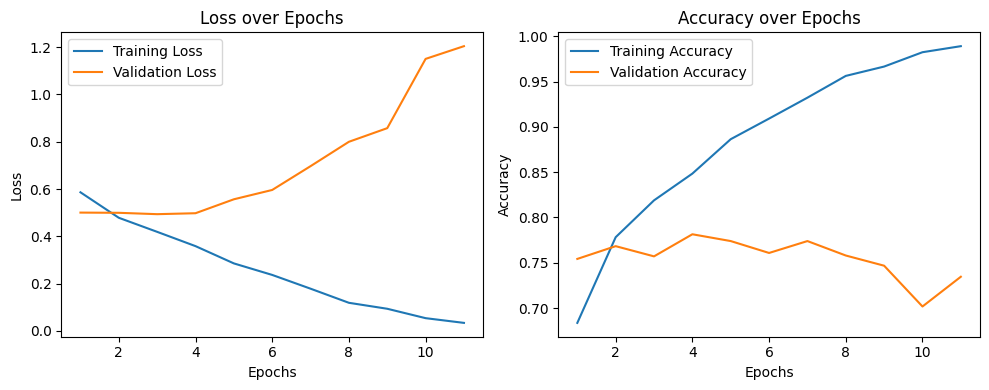

In [30]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1,epoch_count + 1), train_losses, label='Training Loss')
plt.plot(range(1, epoch_count + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_count + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epoch_count + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
#use bilstm instead of rnn
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, bidirectional=True):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) if bidirectional else nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.lstm.bidirectional else hidden[-1, :, :]
        output = self.fc(hidden)
        return output

In [37]:
def objective(trial):
        
        # Suggest hyperparameters
        hidden_dim = trial.suggest_int('hidden_dim', 128, 512, step=64)
        #bidirectional = trial.suggest_categorical('bidirectional', [False, True])
        lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
        batch_size = trial.suggest_categorical('batch_size', [ 64, 128, 256])
    
        # Create datasets and dataloaders with the suggested batch size
        train_data = RTDataset(train_dataset, vocab_new)
        valid_data = RTDataset(validation_dataset, vocab_new)
    
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
        # Initialize the model, criterion, and optimizer with the suggested hyperparameters
        output_dim = 2  # Negative or Positive sentiment
        model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix_new)
        
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD','RMSprop'])
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr)
    
        # Training loop
        num_epochs = 20
        for epoch in range(num_epochs):
            train_acc, train_loss = train(model, train_loader, optimizer, criterion)
            valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
            # Optuna requires a numerical value to minimize (or maximize)
            trial.report(valid_loss, epoch)
            # Handle pruning (optional)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    
        return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-11-03 13:27:43,798] A new study created in memory with name: no-name-8b21a824-8213-4e27-82de-230a9c12c062
C:\Users\Admin\AppData\Local\Temp\ipykernel_33656\2878705518.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-11-03 13:29:32,773] Trial 0 finished with value: 2.3308954791324896 and parameters: {'hidden_dim': 256, 'lr': 0.0028518531222909084, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 0 with value: 2.3308954791324896.
[I 2024-11-03 13:31:25,487] Trial 1 finished with value: 1.53984018137039 and parameters: {'hidden_dim': 512, 'lr': 0.00016181623158587427, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 1 with value: 1.53984018137039.
[I 2024-11-03 13:33:57,788] Trial 2 finished with value: 2.0204578962379727 and parameters: {'hidden_dim': 

Number of finished trials: 20
Best trial:
  Value: 0.8458
  Params:
    hidden_dim: 512
    lr: 0.00010409778675551987
    batch_size: 128
    optimizer: RMSprop


In [38]:
batch_size = 128
train_data = RTDataset(train_dataset, vocab_new)
valid_data = RTDataset(validation_dataset, vocab_new)
test_data = RTDataset(test_dataset, vocab_new)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [56]:
# Instantiate the BiLSTM model, loss function, and optimizer
hidden_dim = 512
output_dim = 2  # Negative or Positive sentiment
bidirectional = True
model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix_new, bidirectional=True).to(device)

#train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), 0.0001040977867555198)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training loop
num_epochs = 50

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
early_stopping = EarlyStopping(patience=5, delta=0.01)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')

    if early_stopping.early_stop:
        print("Early stopping")
        break
# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1:
    Train Loss: 0.5728, Train Acc: 0.7081
    Val Loss: 0.5289, Val Acc: 0.7402
Epoch 2:
    Train Loss: 0.4680, Train Acc: 0.7722
    Val Loss: 0.4753, Val Acc: 0.7589
Epoch 3:
    Train Loss: 0.4273, Train Acc: 0.8001
    Val Loss: 0.4886, Val Acc: 0.7552
Epoch 4:
    Train Loss: 0.3949, Train Acc: 0.8202
    Val Loss: 0.4750, Val Acc: 0.7786
Epoch 5:
    Train Loss: 0.3635, Train Acc: 0.8374
    Val Loss: 0.6143, Val Acc: 0.7223
Epoch 6:
    Train Loss: 0.3349, Train Acc: 0.8546
    Val Loss: 0.4797, Val Acc: 0.7674
Epoch 7:
    Train Loss: 0.3042, Train Acc: 0.8712
    Val Loss: 0.4866, Val Acc: 0.7739
Epoch 8:
    Train Loss: 0.2745, Train Acc: 0.8853
    Val Loss: 0.5793, Val Acc: 0.7486
Epoch 9:
    Train Loss: 0.2480, Train Acc: 0.8978
    Val Loss: 0.6402, Val Acc: 0.7533
Epoch 10:
    Train Loss: 0.2234, Train Acc: 0.9120
    Val Loss: 0.5552, Val Acc: 0.7805
Epoch 11:
    Train Loss: 0.1915, Train Acc: 0.9266
    Val Loss: 0.6257, Val Acc: 0.7786
Epoch 12:
    Train

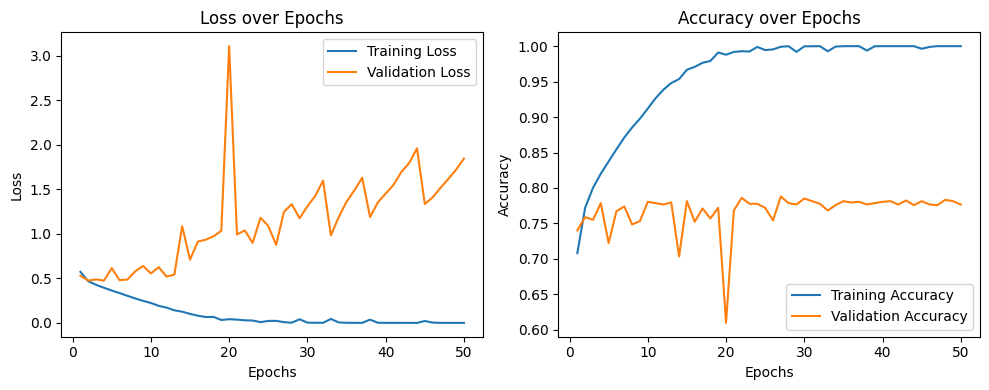

In [57]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
class BiGRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, bidirectional=True):
        super(BiGRUModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) if bidirectional else nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.gru(packed_embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.gru.bidirectional else hidden[-1, :, :]
        output = self.fc(hidden)
        return output

In [60]:
def objective(trial):
        
        # Suggest hyperparameters
        hidden_dim = trial.suggest_int('hidden_dim', 128, 512, step=64)
        #bidirectional = trial.suggest_categorical('bidirectional', [False, True])
        lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
        batch_size = trial.suggest_categorical('batch_size', [ 64, 128, 256])
    
        # Create datasets and dataloaders with the suggested batch size
        train_data = RTDataset(train_dataset, vocab_new)
        valid_data = RTDataset(validation_dataset, vocab_new)
    
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
        # Initialize the model, criterion, and optimizer with the suggested hyperparameters
        output_dim = 2  # Negative or Positive sentiment
        model = BiGRUModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix_new)
        
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD','RMSprop'])
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr)
    
        # Training loop
        num_epochs = 20
        for epoch in range(num_epochs):
            train_acc, train_loss = train(model, train_loader, optimizer, criterion)
            valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
            # Optuna requires a numerical value to minimize (or maximize)
            trial.report(valid_loss, epoch)
            # Handle pruning (optional)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    
        return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-11-03 16:12:02,051] A new study created in memory with name: no-name-d21b727e-a5d7-4c24-8aa2-d49e504e7339
C:\Users\Admin\AppData\Local\Temp\ipykernel_33656\1046875010.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-11-03 16:13:44,580] Trial 0 finished with value: 0.6559264914850804 and parameters: {'hidden_dim': 192, 'lr': 0.006077522145563746, 'batch_size': 128, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6559264914850804.
[I 2024-11-03 16:15:36,862] Trial 1 finished with value: 0.6711241820963417 and parameters: {'hidden_dim': 512, 'lr': 0.00154489995268602, 'batch_size': 64, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6559264914850804.
[I 2024-11-03 16:18:10,911] Trial 2 finished with value: 1.553303769784394 and parameters: {'hidden_dim': 128,

Number of finished trials: 20
Best trial:
  Value: 0.4885
  Params:
    hidden_dim: 256
    lr: 0.01426125171741841
    batch_size: 64
    optimizer: SGD


In [61]:
batch_size =64
train_data = RTDataset(train_dataset, vocab_new)
valid_data = RTDataset(validation_dataset, vocab_new)
test_data = RTDataset(test_dataset, vocab_new)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [62]:
hidden_dim = 256
model = BiGRUModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix_new, bidirectional=True).to(device)

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.01426125171741841)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
# Training loop
num_epochs = 50
epoch_count = 0
early_stopping = EarlyStopping(patience=5, delta=0.01)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    early_stopping(valid_loss, model)

    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')
    epoch_count += 1
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluate on the test set
early_stopping.load_best_model(model)
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1:
    Train Loss: 0.4593, Train Acc: 0.7762
    Val Loss: 0.4870, Val Acc: 0.7542
Epoch 2:
    Train Loss: 0.4586, Train Acc: 0.7805
    Val Loss: 0.4746, Val Acc: 0.7842
Epoch 3:
    Train Loss: 0.4608, Train Acc: 0.7803
    Val Loss: 0.4859, Val Acc: 0.7542
Epoch 4:
    Train Loss: 0.4502, Train Acc: 0.7831
    Val Loss: 0.5269, Val Acc: 0.7430
Epoch 5:
    Train Loss: 0.4545, Train Acc: 0.7762
    Val Loss: 0.4706, Val Acc: 0.7720
Epoch 6:
    Train Loss: 0.4468, Train Acc: 0.7855
    Val Loss: 0.5839, Val Acc: 0.7176
Epoch 7:
    Train Loss: 0.4471, Train Acc: 0.7839
    Val Loss: 0.4714, Val Acc: 0.7833
Early stopping
Test Loss: 0.4973, Test Acc: 0.7533


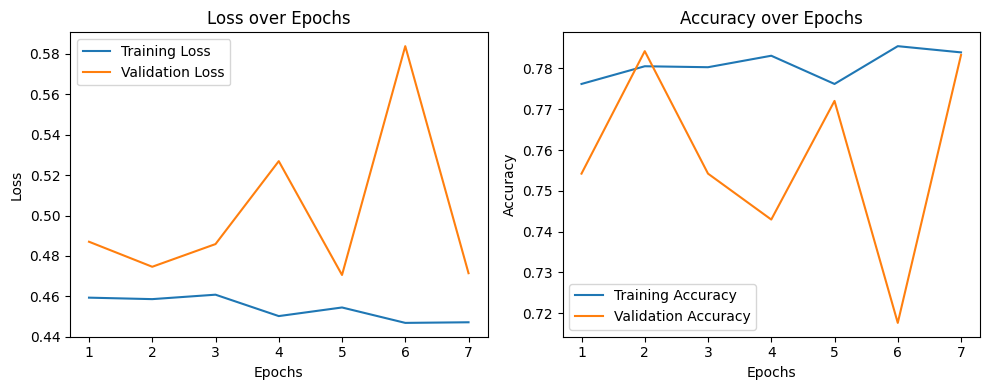

In [72]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch_count + 1), train_losses, label='Training Loss')
plt.plot(range(1, epoch_count + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_count + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epoch_count + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
#use CNN instead of RNN
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, num_filters, filter_sizes):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = torch.cat(pooled, dim=1)
        output = self.fc(cat)
        return output


In [51]:
def objective(trial):
        
        # Suggest hyperparameters
        hidden_dim = trial.suggest_int('hidden_dim', 128, 512, step=64)
        #bidirectional = trial.suggest_categorical('bidirectional', [False, True])
        lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
        batch_size = trial.suggest_categorical('batch_size', [ 64, 128, 256])
        num_filters = trial.suggest_int('num_filters', 64, 256, step=32)
        filter_sizes = [2,4,6]
    
        # Create datasets and dataloaders with the suggested batch size
        train_data = RTDataset(train_dataset, vocab_new)
        valid_data = RTDataset(validation_dataset, vocab_new)
    
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
        # Initialize the model, criterion, and optimizer with the suggested hyperparameters
        output_dim = 2  # Negative or Positive sentiment
        
        model = CNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix_new, num_filters, filter_sizes)
        
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD','RMSprop'])
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr)
    
        # Training loop
        num_epochs = 20
        for epoch in range(num_epochs):
            train_acc, train_loss = train(model, train_loader, optimizer, criterion)
            valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
            # Optuna requires a numerical value to minimize (or maximize)
            trial.report(valid_loss, epoch)
            # Handle pruning (optional)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    
        return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-11-03 15:13:14,950] A new study created in memory with name: no-name-cd5c5439-3e61-422c-b1d9-645f8cf2d5f2
C:\Users\Admin\AppData\Local\Temp\ipykernel_33656\1644265176.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-11-03 15:15:12,783] Trial 0 finished with value: 2.2964752456260666 and parameters: {'hidden_dim': 128, 'lr': 0.012964360062311737, 'batch_size': 256, 'num_filters': 160, 'optimizer': 'Adam'}. Best is trial 0 with value: 2.2964752456260666.
[I 2024-11-03 15:17:44,111] Trial 1 finished with value: 0.6905815444788834 and parameters: {'hidden_dim': 128, 'lr': 0.00030812869724631777, 'batch_size': 256, 'num_filters': 192, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.6905815444788834.
[I 2024-11-03 15:20:06,406] Trial 2 finished with value: 0.652162

Number of finished trials: 20
Best trial:
  Value: 0.5117
  Params:
    hidden_dim: 384
    lr: 0.03606040973360704
    batch_size: 64
    num_filters: 64
    optimizer: SGD


In [52]:
# Instantiate the CNN model, loss function, and optimizer
num_filters = 64
filter_sizes = [2,4,6]
hidden_dim = 384
model = CNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix_new, num_filters, filter_sizes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03606040973360704)

In [53]:
batch_size = 64
train_data = RTDataset(train_dataset, vocab_new)
valid_data = RTDataset(validation_dataset, vocab_new)
test_data = RTDataset(test_dataset, vocab_new)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [55]:
# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training loop
num_epochs = 50

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
early_stopping = EarlyStopping(patience=5, delta=0.1)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')

    if early_stopping.early_stop:
        print("Early stopping")
        break
# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1:
    Train Loss: 0.0060, Train Acc: 1.0000
    Val Loss: 0.6414, Val Acc: 0.7720
Epoch 2:
    Train Loss: 0.0059, Train Acc: 1.0000
    Val Loss: 0.6416, Val Acc: 0.7674
Epoch 3:
    Train Loss: 0.0057, Train Acc: 1.0000
    Val Loss: 0.6441, Val Acc: 0.7674
Epoch 4:
    Train Loss: 0.0055, Train Acc: 1.0000
    Val Loss: 0.6468, Val Acc: 0.7683
Epoch 5:
    Train Loss: 0.0053, Train Acc: 1.0000
    Val Loss: 0.6506, Val Acc: 0.7692
Epoch 6:
    Train Loss: 0.0051, Train Acc: 1.0000
    Val Loss: 0.6514, Val Acc: 0.7683
Epoch 7:
    Train Loss: 0.0050, Train Acc: 1.0000
    Val Loss: 0.6530, Val Acc: 0.7683
Epoch 8:
    Train Loss: 0.0049, Train Acc: 1.0000
    Val Loss: 0.6556, Val Acc: 0.7683
Epoch 9:
    Train Loss: 0.0047, Train Acc: 1.0000
    Val Loss: 0.6572, Val Acc: 0.7702
Epoch 10:
    Train Loss: 0.0046, Train Acc: 1.0000
    Val Loss: 0.6599, Val Acc: 0.7702
Epoch 11:
    Train Loss: 0.0045, Train Acc: 1.0000
    Val Loss: 0.6624, Val Acc: 0.7711
Epoch 12:
    Train